# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

In [1]:
import numpy as np
import scipy
import scipy.sparse as spsp
from scipy import linalg
import scipy as sp
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n):
    b = len(diag_broadcast)
    l = np.zeros((n - 1, (b - 1) // 2))
    u = np.array(diag_broadcast, dtype='float').reshape(1, -1).repeat(n, axis=0)

    for i in range(n - 1):
        for j in range((b - 1) // 2):
            if i + j + 1 >= n:
                    break
            s = max(0, (b - 1) // 2 - j - 1) # start id
            l[i, j] = u[i + j + 1, s] / u[i, s + 1 + j]
            
            for k in range(b-1-j):
                u[i + j + 1, k] = u[i + j + 1, k] - u[i, k + 1 + j] * l[i, j]

    u = u[:, -(b + 1) // 2:]

    return l, u


def banded(diag_broadcast, n):
    b=len(diag_broadcast)
    T = np.zeros((n,n))
    for i in range(n):
        T[i][max(i - (b - 1)//2, 0) : min(i + (b - 1)//2 + 1, n)] = diag_broadcast[-(b - 1)//2 -i-1: (b - 1)//2+(n-i)]
    return T

[[4. 5. 6. 7. 0. 0. 0. 0. 0. 0.]
 [4. 4. 5. 6. 7. 0. 0. 0. 0. 0.]
 [2. 4. 4. 5. 6. 7. 0. 0. 0. 0.]
 [1. 2. 4. 4. 5. 6. 7. 0. 0. 0.]
 [0. 1. 2. 4. 4. 5. 6. 7. 0. 0.]
 [0. 0. 1. 2. 4. 4. 5. 6. 7. 0.]
 [0. 0. 0. 1. 2. 4. 4. 5. 6. 7.]
 [0. 0. 0. 0. 1. 2. 4. 4. 5. 6.]
 [0. 0. 0. 0. 0. 1. 2. 4. 4. 5.]
 [0. 0. 0. 0. 0. 0. 1. 2. 4. 4.]]


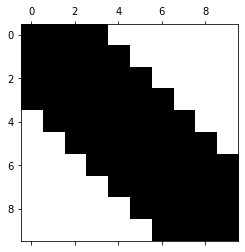

In [3]:
diag_broadcast = [1,2,4,4,5,6,7]
b = len(diag_broadcast)

n = 10

l, u = band_lu(diag_broadcast, n)

lf = np.eye(n)
for i in range(n):
    for j in range((b - 1) // 2):
        if i + j + 1 >= n:
            break
        lf[i+j+1, i] = l[i, j]

uf = np.zeros((n, n))
for i in range(n):
    for j in range((b + 1) // 2):
        if i + j >= n:
            break
        uf[i, i+j] = u[i, j]
        
assert np.linalg.norm(lf @ uf - banded(diag_broadcast, n), ord='fro') < 1e-10, f'Can\'t compute LU for {diag_broadcast} without pivoting'

print(lf @ uf)
plt.spy(lf @ uf)
plt.show()

10it [00:22,  2.29s/it]


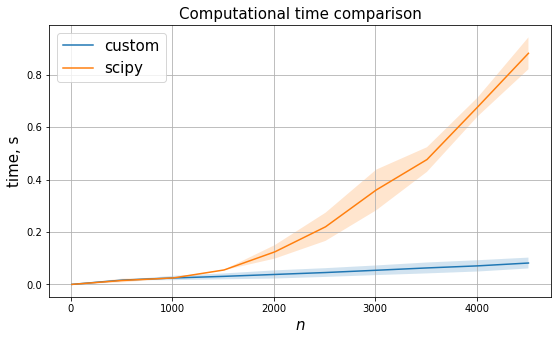

In [4]:
ns = list(range(10, 5000, 500))
ts = np.zeros((len(ns), 2, 2))

diag_broadcast = [1,2,10,4,5,7,8]

for i, n in tqdm(enumerate(ns)):
    nt = 1000 // n

    t = %timeit -o -q -r 7 -n 1 band_lu(diag_broadcast, n)
    ts[i, 0, :] = (t.average, t.stdev)

    matrix = banded(diag_broadcast, n)
    t = %timeit -o -q -r 7 -n 1 sp.linalg.lu(matrix)
    ts[i, 1, :] = (t.average, t.stdev)

plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(ns, ts[:, 0, 0], label='custom')
plt.fill_between(ns, ts[:, 0, 0] - ts[:, 0, 1], ts[:, 0, 0] + ts[:, 0, 1], alpha=0.2)
plt.plot(ns, ts[:, 1, 0], label='scipy')
plt.fill_between(ns, ts[:, 1, 0] - ts[:, 1, 1], ts[:, 1, 0] + ts[:, 1, 1], alpha=0.2)
plt.xlabel(r'$n$', fontsize=15)
plt.ylabel('time, s', fontsize=15)
plt.title('Computational time comparison', fontsize=15)
plt.legend(fontsize=15)
plt.show()

One can see that taking into account sparse structure of the matrix is very important ($O(n)$ vs $O(n^{2,\ldots})$)

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$. 
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

Without pivoting matrix:

$A^{(0)} := A$

$-l_{2,1} = -\dfrac{a^0_{2,1}}{a^0_{1,1}} = -\dfrac{1}{\epsilon}$

$A^{(1)}:= L^{-1}_1 A^{(0)} =  \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-1/\epsilon & 1 \\
0 & 1 & 1
\end{pmatrix}$

$-l_{3,2} = -\dfrac{a^1_{3,2}}{a^1_{2,2}} = -\dfrac{1}{1-1/\epsilon} = -\dfrac{\epsilon}{\epsilon - 1}$

$A^{(2)}: = L^{-1}_2 A^{(1)} = \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-1/\epsilon & 1 \\
0 & 0 & 1 + \frac{\epsilon}{1-\epsilon}
\end{pmatrix} = U$

$L =  \begin{pmatrix}
1 & 0 & 0\\
1/\epsilon & 1 & 0 \\
0 & \frac{\epsilon}{\epsilon -1} & 1
\end{pmatrix}$

With pivoting matrix:

$P =  \begin{pmatrix}
0 & 1 & 0\\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix}$

$ A^{(0)} = PA = \begin{pmatrix}
1 & 1 & 1 \\
\varepsilon & 1 & 0\\
0 & 1 & 1
\end{pmatrix}$

$-l_{2,1} = -\dfrac{a^0_{2,1}}{a^0_{1,1}} = -\epsilon$

$A^{(1)}:= L^{-1}_1 A^{(0)} =  \begin{pmatrix}
1 & 1 & 0\\
0 & 1-\epsilon & -\epsilon \\
0 & 1 & 1
\end{pmatrix}$

$-l_{3,2} = -\dfrac{a^1_{3,2}}{a^1_{2,2}} = -\dfrac{1}{1-\epsilon}$

$A^{(2)}: = L^{-1}_2 A^{(1)} = \begin{pmatrix}
1 & 1 & 0\\
0 & 1-\epsilon & -\epsilon \\
0 & 0 & 1 + \frac{\epsilon}{1-\epsilon}
\end{pmatrix} = U$

$L =  \begin{pmatrix}
1 & 0 & 0\\
\epsilon & 1 & 0 \\
0 & \frac{1}{1 - \epsilon} & 1
\end{pmatrix}$



If $|\epsilon| \ll 1$ $\epsilon \approx \frac{\epsilon}{1-\epsilon} \approx 0, \frac{1}{\epsilon} \rightarrow \infty$ and in floating arithmetic either $\epsilon$ will be lost and changed to $0$ or overfloating will be encountered.

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

__1__
    
$$L = \begin{bmatrix} I_p & 0 \\ A_{21}A^{-1}_{11} & I_q \end{bmatrix}$$

$$LA = \begin{bmatrix} A_{11} & A_{12} \\ 0 & A_{22} - A_{21}A^{-1}_{11}A_{12}\end{bmatrix}$$

$$\Rightarrow S = A_{22} - A_{21}A^{-1}_{11}A_{12}$$

$$Lf = \begin{bmatrix} f_1 \\ - A_{21}A^{-1}_{11}f_1 + f_2 \end{bmatrix}$$

$$\hat{f}_2 = - A_{21}A^{-1}_{11}f_1 + f_2$$

__2__

$$M = \begin{bmatrix} X & -A \\ B & I \end{bmatrix}$$

$$L = \begin{bmatrix} I & 0 \\ -BX^{-1} & I \end{bmatrix}$$

$$LM = \begin{bmatrix} X & -A \\  0 & I + BX^{-1}A \end{bmatrix} = \begin{bmatrix} X & 0 \\  0 & I + BX^{-1}A \end{bmatrix} \begin{bmatrix} I & -X^{-1}A \\  0 & I \end{bmatrix}$$

$$U = \begin{bmatrix} I & -X^{-1}A \\  0 & I \end{bmatrix}$$

$$L^{-1} = \begin{bmatrix} I & 0 \\ BX^{-1} & I \end{bmatrix}$$

$$M = \begin{bmatrix} I & 0 \\ BX^{-1} & I \end{bmatrix}\begin{bmatrix} X & 0 \\  0 & I + BX^{-1}A \end{bmatrix} \begin{bmatrix} I & -X^{-1}A \\  0 & I \end{bmatrix}$$

Now eliminate with respect to $I$:

$$U_2 = \begin{bmatrix} I & A \\ 0 & I \end{bmatrix}$$

$$U_2M = \begin{bmatrix} X + AB & 0 \\ B & I \end{bmatrix} = \begin{bmatrix} X + AB & 0 \\ 0 & I \end{bmatrix} \begin{bmatrix} I & 0 \\ B & I \end{bmatrix}$$

$$L_2 = \begin{bmatrix} I & 0 \\ B & I \end{bmatrix}$$

$$M = \begin{bmatrix} I & -A \\ 0 & I \end{bmatrix}\begin{bmatrix} X + AB & 0 \\ 0 & I \end{bmatrix}  \begin{bmatrix} I & 0 \\ B & I \end{bmatrix}$$

As the determinant of the lower- and uppertriangular matrtices is equal to production of diagonal elements, we get:

$$\text{det}\begin{bmatrix} X + AB & 0 \\ 0 & I \end{bmatrix} = \text{det}\begin{bmatrix} X & 0 \\  0 & I + BX^{-1}A \end{bmatrix}$$

It is easy to see the eqigenspaces of each matrices is a direct sum of non-zero blocks and therefore the determinant is the product of block's determinants:

$$\text{det}(X+AB) = \text{det}(X)\text{det}(I+BX^{-1}A)$$

__3__

$M =  \begin{bmatrix} I_m & F \\ G & I_n \end{bmatrix} =  \begin{bmatrix} I_m & 0 \\ G & I_n \end{bmatrix}  \begin{bmatrix} I_m & 0 \\ 0 & I_n - GF \end{bmatrix}  \begin{bmatrix} I_m & F \\ 0 & I_n \end{bmatrix}$

$M =  \begin{bmatrix} I_m & F \\ 0 & I_n \end{bmatrix}  \begin{bmatrix} I_m - FG & 0 \\ 0 & I_n \end{bmatrix} \begin{bmatrix} I_m & 0 \\ G & I_n \end{bmatrix}$

As in the privious task: determinants of lower- and uppertriangular matrices is 1, determinants of block-diagonal matrices factorize in product of determinants of diagonal blocks.

Therefore $\text{det}(I_n - GF) =\text{det}(I_m - FG)$




### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

__1__ The main idea is to devide and conquer by deviding the matrix into blocks. 

As the task is about LU all the operations will be considered without pivoting, but the sketch of way to PLU is the following:

1. If the desirable size of block is $k$, find the non-singular submatrix $S$ of size $k$ if possible or smaller. Lat its size be $r$.

2. Make the row pivoting $P_r$ and the column pivoting $P_c$ of the devided matrix so that $S$ would be on the left upper corner.

3. Proceed with block LU decomposition of the obtained matrix.

Block LU:


$\begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} = \begin{bmatrix} L_{11}U_{11} & L_{11}U_{12} \\ L_{21}U_{11} & L_{21}U_{12} + L_{22}U_{22} \end{bmatrix}$

1. $A_{11} = L_{11}U_{11}$

2. do in parallel (if possible): $U_{12} = L_{11}^{-1}A_{12}$, $L_{21} = A_{21}U_{11}^{-1}$. 
   
   If $A_{11}$ is dense and parallelism is on: $L_{22}U_{22} = A_{22} - A_{21}A_{11}^{-1}A_{12}$. 

   If $A_{11}$ is sparse and parallelism is on: $L_{22}U_{22} = A_{22} - A_{21}U_{11}^{-1}L_{11}^{-1}A_{12}$.
   
   If no parallelism: $L_{22}U_{22} = A_{22} - L_{21}U_{12}$.

    The deviding may be completed recursively



In [5]:
import scipy as sp 
from functools import partial

def naive_lu(A):
    n = len(A)
    l = np.zeros((n, n))
    u = np.zeros((n, n))

    for j in range(n):
        l[j, j] = 1.0
        for i in range(j + 1):
            s1 = sum(u[k, j] * l[i, k] for k in range(i))
            u[i, j] = A[i, j] - s1
        for i in range(j, n):
            s2 = sum(u[k, j] * l[i, k] for k in range(j))
            l[i, j] = (A[i, j] - s2) / u[j, j]

    return l, u

def block_lu(A, r, lu_func):
    l11, u11 = lu_func(A[:r, :r])
    
    u12 = sp.linalg.solve_triangular(l11, sp.eye(l11.shape[0]), lower=True, unit_diagonal=True) @ A[:r, r:]
    l21 = A[r:, :r] @ sp.linalg.solve_triangular(u11, sp.eye(u11.shape[0]), lower=False, unit_diagonal=False)
    
    l22, u22 = lu_func(A[r:, r:] - l21 @ u12)
    #l22, u22 = lu_func(A[r:, r:] - A[r:, :r] @ sp.linalg.inv(A[:r, :r]) @ A[:r, r:])
    
    l = sp.zeros((A.shape[0], A.shape[0]))
    u = sp.zeros((A.shape[0], A.shape[0]))
    
    l[:r, :r] = l11
    l[r:, :r] = l21
    l[r:, r:] = l22

    u[:r, :r] = u11
    u[:r, r:] = u12
    u[r:, r:] = u22

    return l, u


rmin = 10
lu_func = lambda a: block_lu(a, a.shape[0] // 2, lu_func) if a.shape[0] >= rmin else naive_lu(a)

In [6]:
a = np.random.rand(1000, 1000) 
l, u = lu_func(a)

assert sp.linalg.norm(a - l @ u, ord='fro') < 1e-4, sp.linalg.norm(a - l @ u, ord='fro')

In [7]:
ns = np.arange(50, 2000, 100)
ts = np.zeros((len(ns), 3, 2))

for ni, n in tqdm(enumerate(ns)):
    for i, func in enumerate([lu_func, naive_lu, sp.linalg.lu]):
        if n > 200 and func is naive_lu:
            continue
        t = %timeit -o -q -r 7 -n 1 func(np.random.rand(n, n))
        ts[ni, i, :] = (t.average, t.stdev)

20it [01:07,  3.38s/it]


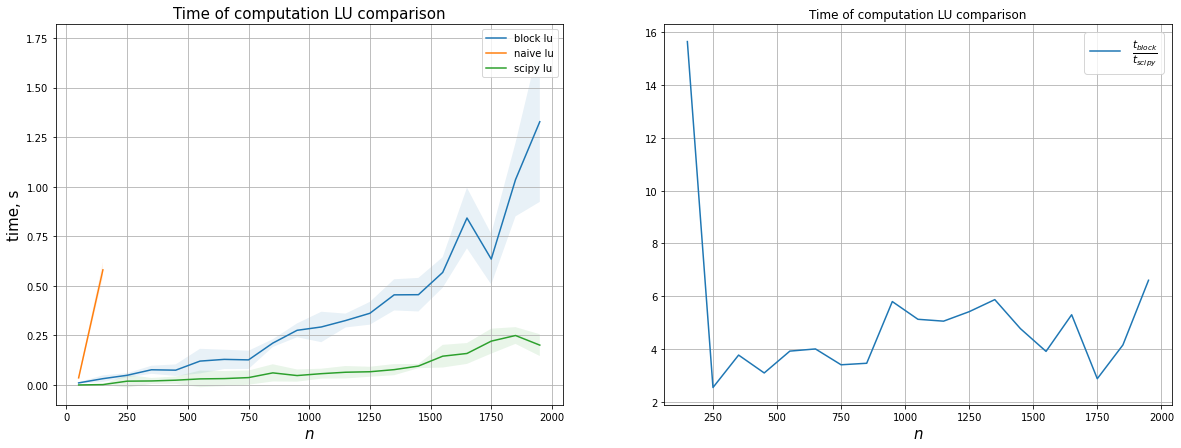

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 7))
axs[0].grid()
axs[0].plot(ns, ts[:, 0, 0], label='block lu')
axs[0].fill_between(ns, ts[:, 0, 0] - ts[:, 0, 1], ts[:, 0, 0] + ts[:, 0, 1], alpha=0.1)
axs[0].plot(ns[:2], ts[:, 1, 0][:2], label='naive lu')
axs[0].fill_between(ns[:2], ts[:, 1, 0][:2] - ts[:, 1, 1][:2], ts[:, 1, 0][:2] + ts[:, 1, 1][:2], alpha=0.1)
axs[0].plot(ns, ts[:, 2, 0], label='scipy lu')
axs[0].fill_between(ns, ts[:, 2, 0] - ts[:, 2, 1], ts[:, 2, 0] + ts[:, 2, 1], alpha=0.1)
axs[0].legend()
axs[0].set_xlabel(r'$n$', fontsize=15)
axs[0].set_ylabel(r'time, s', fontsize=15)
axs[0].set_title('Time of computation LU comparison', fontsize=15)

axs[1].grid()
axs[1].plot(ns[1:], ts[:, 0, 0][1:] / ts[:, 2, 0][1:], label=r'$\frac{t_{block}}{t_{scipy}}$')
axs[1].legend(fontsize=15)
axs[1].set_title('Time of computation LU comparison')
axs[1].set_xlabel(r'$n$', fontsize=15)
plt.show()

Summary: 

Although using block LU significantly improves performance, it still loses to scipy implementation by a constant factor $\sim 5$. One should think about parallelizing intermediate computations 

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

__1__  if  A normal then exist unitary matrix $U$ such that $A = U\Lambda U^*$, where $\Lambda$ is diagonal matrix with eigenvalues of $A$ (Schur theorem). 

if A is Hermitian then $U\Lambda U^* = U \Lambda^* U^* \Rightarrow U^*U\Lambda U^*U = U^*U\Lambda^* U^*U = \Lambda = \Lambda^* \Rightarrow$ eigenvalues are real. 

if its eigenvalues are real them $A^* =  U\Lambda^* U^*  = U\Lambda U^* = A$.

if $A$ is unitary then $AA^* = A^*A = U\Lambda^*\Lambda U^* = U\text{diag}(\lambda_1^2, \ldots, \lambda_n^2)U^* = UDU^* = I$, $D = U^* I U = I \Rightarrow |\lambda_i| = 1$

if $|\lambda| =1$ for all eigenvalues then $AA^* = A^*A = UDU^* = UU^* = I$

__2__ 

Let's consider that $\varepsilon > 0$.

We'll compute the determinant w.r. to the first column.

$\det (J(\epsilon) - \nu I) = \lambda \det \begin{bmatrix} 
     \lambda - \nu & 1 & & & 0 \\ 
     & \lambda - \nu & 1 & & \\ 
     &  & \ddots - \nu & \ddots & \\ 
     & & & \lambda - \nu & 1 \\ 
    & & & & \lambda - \nu  \\ 
    \end{bmatrix}_{(n-1) \times (n-1)} + (-1)^{n-1} \varepsilon \det \begin{bmatrix} 
      1 & \lambda  - \nu & & & 0 \\ 
     & 1 & \lambda - \nu & & \\ 
     &  & \ddots & \ddots & \\
    & & & 1 & \lambda - \nu\\   
   & & &  & 1 &\\ 
    \end{bmatrix}_{(n-1)\times (n-1)}$ 

$ = (\lambda - \nu) (\lambda- \nu)^{n-1} + (-1)^{n-1}\varepsilon \cdot 1 = 0$

$(\lambda- \nu)^n = (-1)^n\varepsilon = \varepsilon e^{i\pi n}$

$(\lambda - \nu_k) = \varepsilon^{\frac{1}{n}}e^{i\left(\pi + \frac{2\pi k}{n}\right)}, ~k=0 \ldots n-1$


$\nu_k = \lambda - \varepsilon^{\frac{1}{n}}e^{i\left(\pi + \frac{2\pi k}{n}\right)} = \lambda + \varepsilon^{\frac{1}{n}}e^{i\frac{2\pi k}{n}}, ~~k=0 \dots n-1$

 Eigenvalues of $J(0)$ are $(\lambda, \ldots, \lambda)$ therefore computation is stable. 

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [9]:
from scipy import sparse as spsp

# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix

def pagerank_matrix(G):
    A = G.copy()
    ks = np.asarray(A.sum(axis=1)).flatten()

    if spsp.issparse(A):
        ia = A.indptr
        ja = A.indices
        sa = A.data
    
        for i in range(A.shape[0]):
            ind_range = np.arange(ia[i], ia[i+1])
            if ks[i]:
                A.data[ind_range] = A.data[ind_range] / ks[i]

        A = A.T
    else:
        A = G.T.copy()
        A[:, np.where(~A.any(axis=1))[0]] = 1
        A = A / ks[None, :]

    return A

In [10]:
# sanity check
G = np.random.binomial(1, 0.02, (10, 10))
A = pagerank_matrix(G)

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have? 


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$. 

In [11]:
G = np.array([[0, 1, 0, 0, 0], 
            [0, 0, 1, 0, 0], 
            [1, 1, 0, 0, 0], 
            [0, 0, 0, 0, 1], 
            [0, 0, 0, 1, 0]], dtype=float)
            
Gsp = spsp.csr_matrix(G)
A = pagerank_matrix(G)
Asp = pagerank_matrix(Gsp)
assert np.isclose(A, Asp.toarray()).all()
print(f'A: \n {A}')

A: 
 [[0.  0.  0.5 0.  0. ]
 [1.  0.  0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]


In [12]:
print(f'Eigenvalues (largest = 1, multiplicativity = 2): {np.linalg.eigvals(A)}')

Eigenvalues (largest = 1, multiplicativity = 2): [-0.5+0.5j -0.5-0.5j  1. +0.j   1. +0.j  -1. +0.j ]


But we are interested in eigenvalue of largest absolute magnitude and there is an eigenvalue $-1$ with multiplicativity $1$. 

Moreover eigenvalue $1$ has multiplicativity $2$ which is bad, cause markov chain with transition kernel $A$ has not a single stationary distribution or none at all 

In our case it has a periodic state.

In [13]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
from tqdm import trange

def power_method(A, x0, num_iter): # 5 pts
    res = []
    x = x0 / np.linalg.norm(x0, ord=2)

    for i in range(num_iter + 1):
        Ax = A @ x
        l = Ax @ x
        res.append(np.linalg.norm(Ax - l * x, 2))

        if i != num_iter:
            x = Ax
            x = x / np.linalg.norm(x, 2)
    return x, l, res

In [14]:
x, l, res = power_method(np.array([[2, -1], [-1, 2]]), np.random.rand(2), 10)
print()
print(f'Largest eigenvalue: {l:.5f}')


Largest eigenvalue: 3.00000


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.


lambda: 0.903+-0.099


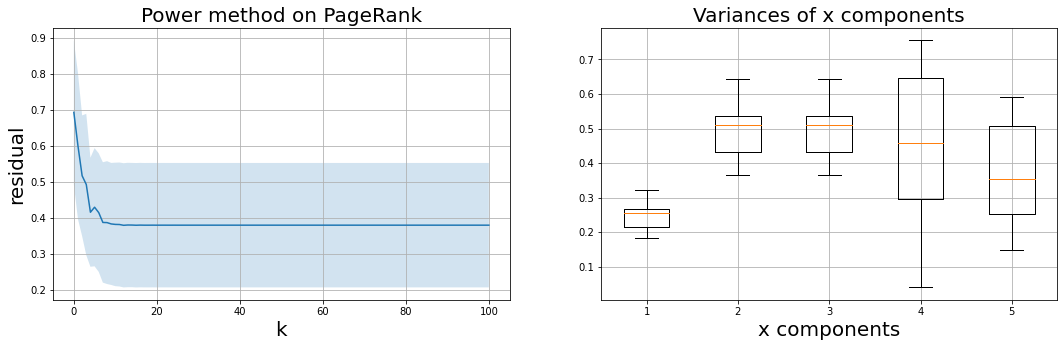

In [15]:
xs = np.zeros((10, 5))
res = np.zeros((10, 101))
ls = np.zeros(10)
for i in range(10):
    x0 = np.random.rand(5)
    xs[i], ls[i], res[i] = power_method(A, x0, 100)
print(f'\nlambda: {ls.mean():.3f}+-{ls.std():.3f}')

fig, axs = plt.subplots(ncols=2, figsize=(18, 5))
axs[0].plot(np.arange(res.shape[1]), res.mean(0))
axs[0].fill_between(np.arange(res.shape[1]), res.mean(0)-res.std(0), res.mean(0)+res.std(0), alpha=0.2)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on PageRank', fontsize=20)

axs[1].boxplot(xs)
axs[1].grid()
axs[1].set_xlabel('x components', fontsize=20)
axs[1].set_title('Variances of x components', fontsize=20)
plt.show()

The assumption that the matrix has one dominant eigenvalue doesn't imply and the vector oscilates between eigenvector of eigenvalue $-1$ and a linear combination of eigenvectors of eigenvalue $1$.


lambda: 1.000+-0.000


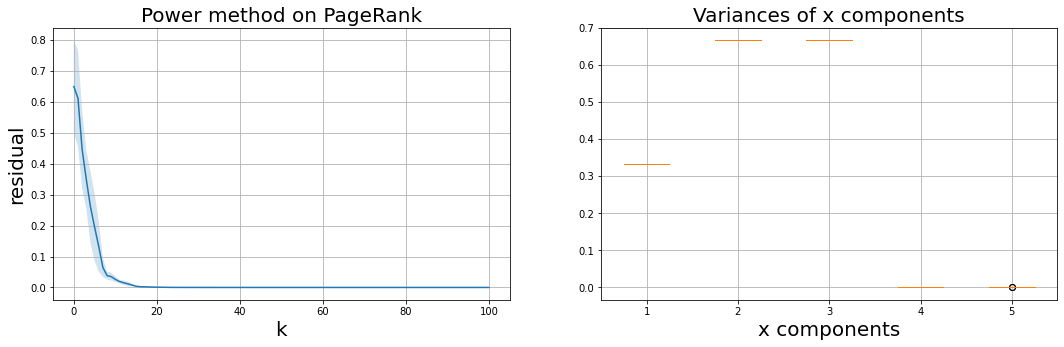

In [16]:
G = np.array([[0, 1, 0, 0, 0], 
            [0, 0, 1, 0, 0], 
            [1, 1, 0, 0, 0], 
            [0, 0, 0, 0, 1], 
            [1, 0, 0, 1, 0]])

A_4loop = pagerank_matrix(G)

xs = np.zeros((10, 5))
res = np.zeros((10, 101))
ls = np.zeros(10)
for i in range(10):
    x0 = np.random.rand(5)
    xs[i], ls[i], res[i] = power_method(A_4loop, x0, 100)
print(f'\nlambda: {ls.mean():.3f}+-{ls.std():.3f}')

fig, axs = plt.subplots(ncols=2, figsize=(18, 5))
axs[0].plot(np.arange(res.shape[1]), res.mean(0))
axs[0].fill_between(np.arange(res.shape[1]), res.mean(0)-res.std(0), res.mean(0)+res.std(0), alpha=0.2)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on PageRank', fontsize=20)

axs[1].boxplot(xs)
axs[1].grid()
axs[1].set_xlabel('x components', fontsize=20)
axs[1].set_title('Variances of x components', fontsize=20)
plt.show()

In [17]:
print(f'Eigenvalues (largest = 1, multiplicativity = 1): {np.linalg.eigvals(A_4loop)}')

Eigenvalues (largest = 1, multiplicativity = 1): [-0.5       +0.5j -0.5       -0.5j  1.        +0.j   0.70710678+0.j
 -0.70710678+0.j ]


As now there is only one dominant eigenvalue $1$ with multiplicativity $1$ the power method converges. And actually approximated eigenvectors don't depend on the initial guesses


lambda: 1.000+-0.000


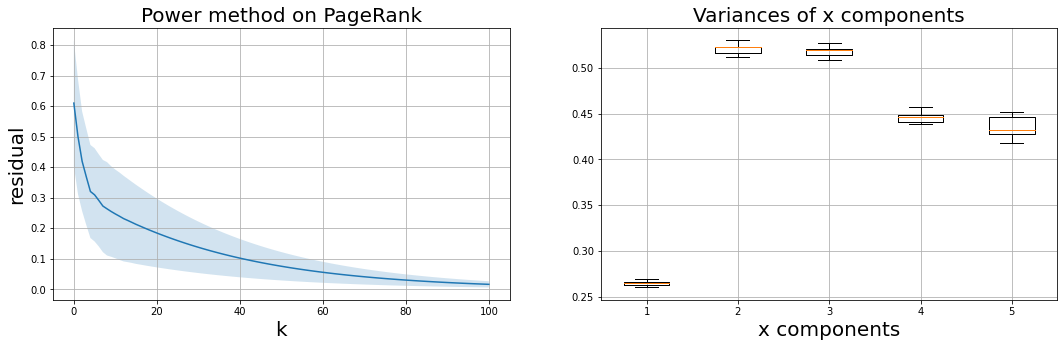

In [18]:
d = 0.97

Ad = d * A + (1 - d) / A.shape[0] * np.ones((A.shape[0], A.shape[0]))

xs = np.zeros((10, 5))
res = np.zeros((10, 101))
ls = np.zeros(10)
for i in range(10):
    x0 = np.random.rand(5)
    xs[i], ls[i], res[i] = power_method(Ad, x0, 100)
print(f'\nlambda: {ls.mean():.3f}+-{ls.std():.3f}')

fig, axs = plt.subplots(ncols=2, figsize=(18, 5))
axs[0].plot(np.arange(res.shape[1]), res.mean(0))
axs[0].fill_between(np.arange(res.shape[1]), res.mean(0)-res.std(0), res.mean(0)+res.std(0), alpha=0.2)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on PageRank', fontsize=20)

axs[1].boxplot(xs)
axs[1].grid()
axs[1].set_xlabel('x components', fontsize=20)
axs[1].set_title('Variances of x components', fontsize=20)
plt.show()

In [19]:
# second largest eigenvalue equals d

assert np.abs(np.sort(np.linalg.eigvals(Ad))[::-1][1] - d) < 1e-7

Convergence rate $ = 1/d$

In [20]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)

# working realization, but still producing not correct answer for the next task and that is weird
def pagerank_matvec(A, d, x): # 2 pts
    n = A.shape[0]

    ia = A.indptr
    ja = A.indices
    sa = A.data

    y = np.zeros_like(x)
    for i in range(n):
        for k in range(ia[i], ia[i+1]):
            y[i] += sa[k] * x[ja[k]]
    y *= d
    y += (1-d) / n * x.sum()
        
    return y


In [21]:
n = 1000
m = 100
d = 0.85

array = np.array([1] * m + [0] * (n * n - m))
np.random.shuffle(array)

random_mat = array.reshape((n, n))
random_mat_sparse = spsp.csr_matrix(random_mat)
x = np.random.rand(n)

In [22]:
%timeit pagerank_matvec(random_mat_sparse, d, x)
%timeit (d * random_mat + (1 - d) / n * np.ones(random_mat.shape)) @ x

sparse_res = pagerank_matvec(random_mat_sparse, d, x)
res = (d * random_mat + (1 - d) / n * np.ones(random_mat.shape)) @ x

assert np.isclose(sparse_res, res).all()

645 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.09 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [23]:
# !gdown "https://drive.google.com/u/0/uc?id=1a77VOi_XAOXQLGEsVauBHU5WpnzyS57-&export=download"
# !unzip -a dblp.zip

In [61]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [62]:
print(f'Density: {(G != 0).sum() / np.prod(G.shape)}')

Density: 4.4986518152305776e-05


In [63]:
cited_n = np.asarray(G.sum(axis=0)).flatten()
top_ind = np.argsort(cited_n)[-10:]
print('Top cited authors: \n', '\n'.join(authors[top_ind]))

Top cited authors: 
 David G. Lowe
David E. Culler
Ion Stoica
Jitendra Malik
Cordelia Schmid
Anil K. Jain
Jiawei Han
Hari Balakrishnan
Andrew Zisserman
Scott Shenker


In [64]:
G.data[G.data.nonzero()] = 1.0
A = pagerank_matrix(G)
sums = A.sum(axis=0)

# check A is proper matrix

assert sums[sums != 0].sum() == sums[sums != 0].shape[1]

In [65]:
cited_n = np.asarray(G.sum(axis=0)).flatten()
top_ind = np.argsort(cited_n)[-10:]
print('Top cited authors: \n', '\n'.join(authors[top_ind]))

Top cited authors: 
 Jiawei Han
Vladimir Vapnik
Michael I. Jordan
David E. Goldberg
Jitendra Malik
David G. Lowe
Scott Shenker
Chih-Jen Lin
Anil K. Jain
Hari Balakrishnan


In [66]:
s = A.sum(axis=0)
assert np.isclose(s[s.nonzero()], 1).all()

In [60]:
from scipy.sparse import linalg

d = 0.85

L = spsp.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

In [61]:
n_iter = 10

x0 = np.ones(A.shape[0])
x, l, res = power_method(L, x0, n_iter)

In [62]:
# seems like not bad result, but...
 
print(f'lambda: {l:.4f}')

lambda: 0.9623


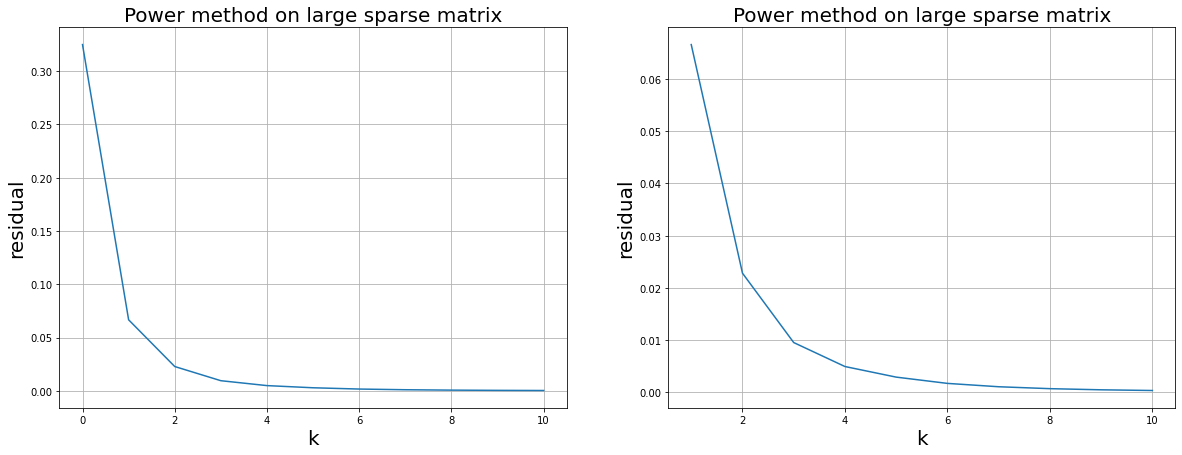

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

axs[0].plot(np.arange(len(res)), res)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on large sparse matrix', fontsize=20)

axs[1].plot(np.arange(len(res))[1:], res[1:])
axs[1].grid()
axs[1].set_xlabel('k', fontsize=20)
axs[1].set_ylabel('residual', fontsize=20)
axs[1].set_title('Power method on large sparse matrix', fontsize=20)
plt.show()

In [64]:
# Oops, what a weird squad?

top_authors_ind = np.argsort(x)[-10:][::-1]
print('\n'.join(authors[top_authors_ind]))

Yeliz Cavusoglu
Noriaki Onodera
Ákos Nemcsics
Milan S. Dimitrijevic
Eiki Izumi
Kunio Kashiwagi
Sagirkaya E
Katya P. Tsvetkova
Janos P. Makai
Kazuyoshi Yamada


Here is what I get if apply pagerank_matvec realization presented above. I've checked that the result of both naive and that realization are the same, BUT when apply it for power method it took quite long time and produced strange result (list of authors). Therefore below I apply naive realization and suprisingly it works quite fast and produce good list of authors. That is very strange and actually I don't know why it happens.

In [67]:
from scipy.sparse import linalg

In [68]:
%%time
#naive realization of pagerank_matvec (fast!)

def pagerank_matvec2(A, d, x): # 2 pts
    n = x.shape[0]
    y = A @ x
    y *= d
    y += (1-d) / n * x.sum() * np.ones(x.shape[0])
        
    return y

L2 = spsp.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec2(A, d, x))

n_iter = 10

x0 = np.ones(A.shape[0])
x, l, res = power_method(L2, x0, n_iter)

CPU times: user 21.6 s, sys: 6.07 s, total: 27.7 s
Wall time: 20.2 s


In [69]:
# still nice result

print(f'lambda: {l}')

lambda: 0.9631392268984206


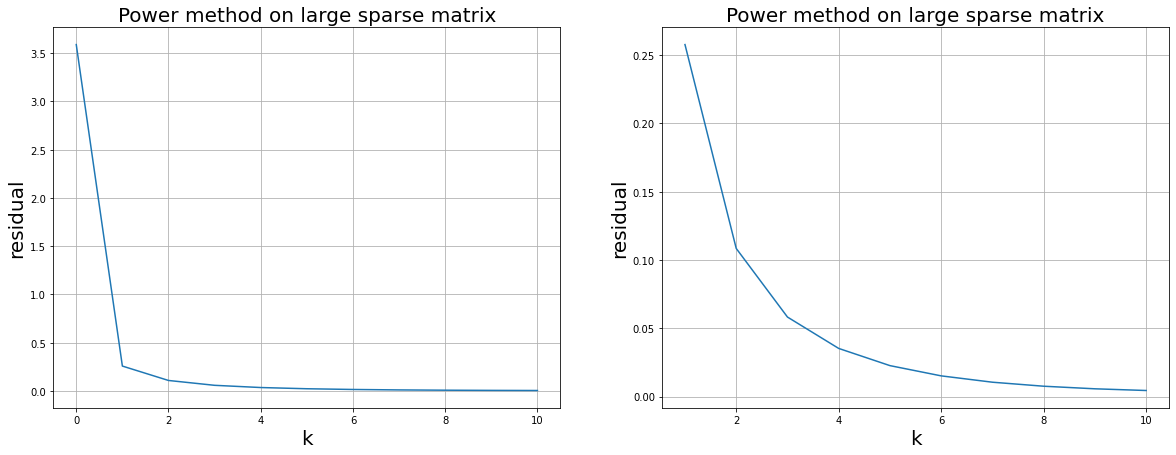

In [70]:
# convergence is even better!

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

axs[0].plot(np.arange(len(res)), res)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on large sparse matrix', fontsize=20)

axs[1].plot(np.arange(len(res))[1:], res[1:])
axs[1].grid()
axs[1].set_xlabel('k', fontsize=20)
axs[1].set_ylabel('residual', fontsize=20)
axs[1].set_title('Power method on large sparse matrix', fontsize=20)
plt.show()

In [71]:
# that is the correct list
# Now I even know some of these guys! 

top_authors_ind = np.argsort(x)[-10:][::-1]
print('\n'.join(authors[top_authors_ind]))

David E. Goldberg
Richard M. Karp
Azriel Rosenfeld
John E. Hopcroft
Ronald L. Rivest
Anil K. Jain
Takeo Kanade
Alfred V. Aho
Robert Endre Tarjan
Gerard Salton


In [72]:
%%time
#even more naive realization, without damping factor for simplicity, just prooj of concept 

n_iter = 10

x0 = np.ones(A.shape[0])
x, l, res = power_method(A, x0, n_iter)

CPU times: user 16.1 s, sys: 6.48 s, total: 22.6 s
Wall time: 14.9 s


In [73]:
print(f'lambda: {l}')

lambda: 0.9873366805295952


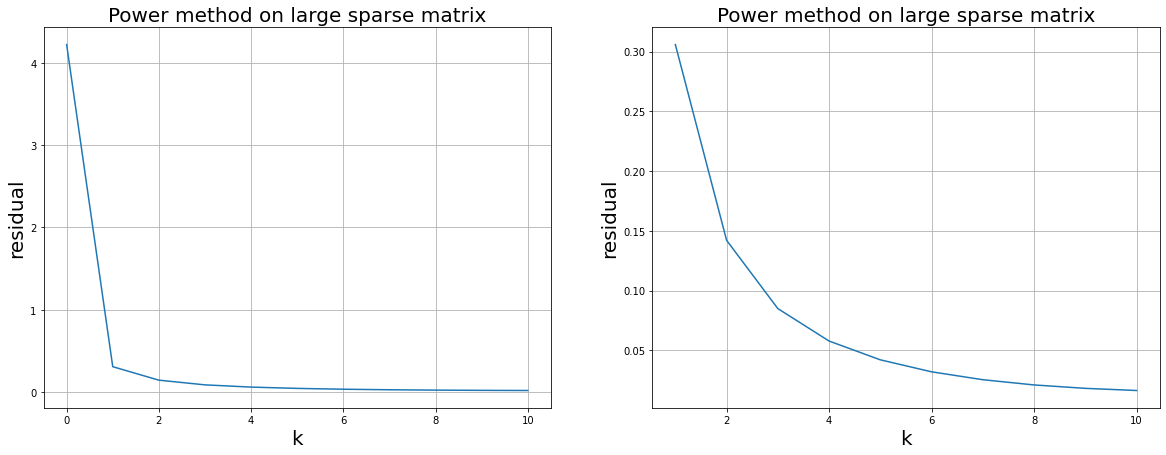

In [74]:
# here onvergence suffers a bit...

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

axs[0].plot(np.arange(len(res)), res)
axs[0].grid()
axs[0].set_xlabel('k', fontsize=20)
axs[0].set_ylabel('residual', fontsize=20)
axs[0].set_title('Power method on large sparse matrix', fontsize=20)

axs[1].plot(np.arange(len(res))[1:], res[1:])
axs[1].grid()
axs[1].set_xlabel('k', fontsize=20)
axs[1].set_ylabel('residual', fontsize=20)
axs[1].set_title('Power method on large sparse matrix', fontsize=20)
plt.show()

In [75]:
# not absolutely correct list (no damping factor used)
# but still good

top_authors_ind = np.argsort(x)[-10:][::-1]
print('\n'.join(authors[top_authors_ind]))

Richard M. Karp
John E. Hopcroft
Azriel Rosenfeld
Ronald L. Rivest
Alfred V. Aho
Alan J. Perlis
Robert Endre Tarjan
Donald E. Knuth
Takeo Kanade
Michael Stonebraker


Of course the last list differ from the one above but it is still good comparing to the first list (with sparse realization). 

So I will consider the second list:

As one can see top ranked authors differ from top cited authors as Page Rank takes into account the importance of citing persons, not only the number of them. 


### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [76]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration

def qr_algorithm(A_init, num_iter): # 3 pts
    convergence = []
    Ak = A_init

    for iter in range(num_iter):
        q, r = np.linalg.qr(Ak)
        Ak = r @ q
        convergence.append(np.max(np.abs(np.tril(Ak, k=-1))))

    return Ak, np.array(convergence)

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

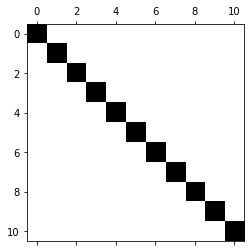

In [77]:
A = 2*np.eye(11)
A[1:,:-1] += -1 * np.eye(10)
A[:-1,1:] += -1 * np.eye(10)

Ak, convergence = qr_algorithm(A, 400)
plt.spy(Ak, precision=1e-7)
plt.show()

In [78]:
np.linalg.eigvals(A)

array([3.93185165, 3.73205081, 3.41421356, 3.        , 2.51763809,
       2.        , 1.48236191, 0.06814835, 0.26794919, 0.58578644,
       1.        ])

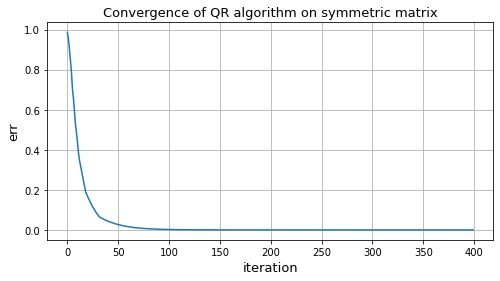

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(400), convergence)
plt.grid()
plt.title('Convergence of QR algorithm on symmetric matrix', fontsize=13)
plt.xlabel('iteration', fontsize=13)
plt.ylabel('err', fontsize=13)
plt.show()

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

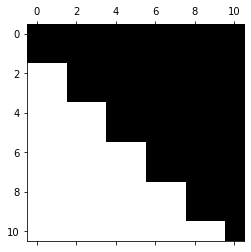

In [80]:
# Your solution 
A = 3*np.eye(11)
A[1:,:-1] += -5 * np.eye(10)
A[:-1,1:] += 2 * np.eye(10)

Ak, convergence = qr_algorithm(A, 250)
plt.spy(Ak, precision=1e-7)
plt.show()

In [81]:
print(Ak[1, 0])

-6.234665033058793


Matrix $A_k$ is not upper-triangular ((

In [82]:
np.linalg.eigvals(A)

array([3.+6.10905132j, 3.-6.10905132j, 3.+5.47722558j, 3.-5.47722558j,
       3.+4.47213595j, 3.-4.47213595j, 3.+1.63691537j, 3.-1.63691537j,
       3.+0.j        , 3.+3.16227766j, 3.-3.16227766j])

$A$ has two eigenvalues of same magnitude and perhaps therefore QR-algoritm may not converge

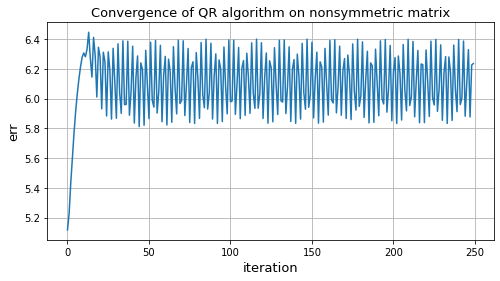

In [83]:
plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(np.arange(250), convergence)
plt.title('Convergence of QR algorithm on nonsymmetric matrix', fontsize=13)
plt.xlabel('iteration', fontsize=13)
plt.ylabel('err', fontsize=13)
plt.show()

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.
Note that in order to solve that subproblem you should firstly prove the following fact:

    Let $S \in \mathbb{C}^{m \times n},\ m \ge n,\ J = \text{diag}(\pm 1).$ If $A = S^{*}JS$ and $det(A) \ne 0$, then exists QR decomposition of $S$ with respect to $J$: 
    $$S = P_1 QR P_2^{*} = P_1 Q \begin{bmatrix} R_1 \\ 0 \end{bmatrix} P_2^{*}, \ Q^{*} J^{'}Q = J^{'}, \ J^{'} = P_1^{*}JP_1,$$ where $P_1$ and $P_2$ are permutation matrices, $Q$ is called $J^{'}$- unitary and $R_1$ is almost triangular.


__1__ 

If $T_{21} = 0$ then first column of $VT$ is $v_1 T_{11}$. Therefore from  equality $AV [Av_1 \ldots Av_n]= VT$ we get $Av_1 = T_{11}v_1 \Rightarrow v_1$ - eigenvector of $A$ - contradiction.

__2__ 

Let $A$ be $J$-decomposable. Then it's pseudoschur J-decomposable with $T_{21} = 0$. Therefore $v_1$ is eigenvector of $A$. $A$ has to eigenvectors: $[1, -1], ~[1, 1]$. 

Let $V = \begin{bmatrix} a & b \\a & c\end{bmatrix}$. Then we can write $a^2 - b^2 = \pm 1,~a^2-c^2=\pm 1$ and $a^2-bc=0 \Rightarrow$


$b(b-c) = \pm 1, ~c(b-c) = \pm 1, ~a^2 -bc = 0$

$\Rightarrow b\ne 0,c\ne 0,b-c\ne 0 \Rightarrow \frac{b(b-c)}{c(b-c)} = \pm 1  \Rightarrow b=-c$

Now we consider case $a^2 = -b^2,~1=-2b^2$

Therefore $b = \pm ia,~~a=\pm\frac{1}{\sqrt 2}$

$V = \frac{1}{\sqrt 2}\begin{bmatrix}1 & i \\ 1 & -i \end{bmatrix}$

$V^{-1} = \frac{1}{\sqrt 2}\begin{bmatrix}1 & 1 \\ -i & i \end{bmatrix}$

$T = \begin{bmatrix} 2 & 0\\ 0 & 4 \end{bmatrix}$

$A = VTV^{-1}$

Thus it turns out that $A$ is $J$-decomposable







In [84]:
#check
A = np.array([[3, -1], [-1, 3]])
print(f'A = \n{A}\n')
V = 1/2**.5 * np.array([[1, 1j], [1, -1j]])
print(f'V = {1/2**.5} * \n{V / (1/2**.5)}\n')
T = np.array([[2, 0], [0, 4]])
print(f'T = \n{T}\n')

assert np.isclose(A, V @ T @ np.linalg.inv(V)).all()

A = 
[[ 3 -1]
 [-1  3]]

V = 0.7071067811865475 * 
[[1.+0.j 0.+1.j]
 [1.+0.j 0.-1.j]]

T = 
[[2 0]
 [0 4]]



## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [85]:
N = 5000
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
xx, yy = np.meshgrid(x, y, sparse=True)
A = np.exp(-(xx**2 + yy**2)**0.5)

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


100%|██████████| 250/250 [00:49<00:00,  5.00it/s]

Relative error mean: 0.00328, std: 0.00609


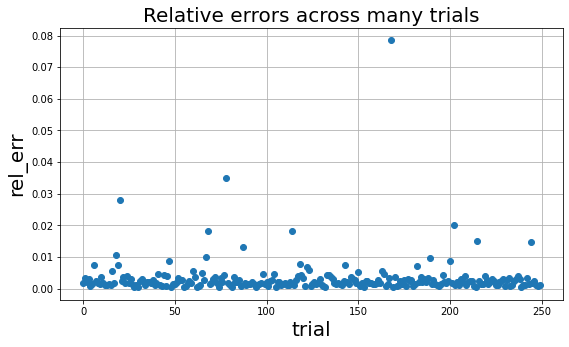

In [86]:
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

r = 5
M = 250
rel_err = np.zeros(M)

for i in trange(M):
    A_sk = np.zeros((r, r))
    while np.linalg.cond(A_sk) > 1e6:
        row_index_set = np.random.choice(np.arange(N), r)
        column_index_set = np.random.choice(np.arange(N), r)
        A_sk = A[row_index_set, :][:, column_index_set]

    Ar = A[:, column_index_set] @ np.linalg.inv(A_sk) @ A[row_index_set, :]
    rel_err[i] = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')

print()
print(f'Relative error mean: {rel_err.mean():.5f}, std: {rel_err.std():.5f}')
plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(np.arange(M), rel_err, marker='o', linestyle="")
plt.xlabel('trial', fontsize=20)
plt.ylabel('rel_err', fontsize=20)
plt.title('Relative errors across many trials', fontsize=20)
plt.show()

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

step 0. Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

step 1. Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

step 2. **If $|b_{ij}| > 1 + \delta$, then**:

Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

**elseif $|b_{ij}| < 1 + \delta$**:
    
    return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 3 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [87]:
from numpy import unravel_index

delta = 1e-2


def dominant_submatrix_search(A):
    Acopy = A.copy()
    N = A.shape[0]
    r = A.shape[1]
    A_dom = np.zeros((r, r))
    
    it = 0
    while np.linalg.cond(A_dom) > 1e6 and it < 100:
        row_indices = np.random.choice(np.arange(N), r)
        A_dom = A[row_indices, :]
        it += 1

    rest_rows = np.array(list(set(np.arange(N)) - set(row_indices)))
    A = np.concatenate([A_dom, A[rest_rows, :]], axis=0)
    all_indices = np.concatenate([row_indices, rest_rows])

    A_dom_inv = None
    it = 0   
    while it < N:
        if A_dom_inv is None:
            try:
                A_dom_inv = np.linalg.inv(A_dom)
            except np.linalg.LinAlgError:
                print(f'Oops.. Can\'t find non-singular dominant submatrix of rank {r}, please try lower rank')
                return row_indices

        else:
            #assert np.isclose(np.linalg.inv(A_dom), A_dom_inv - np.outer(A_dom_inv @ u, (v @ A_dom_inv)) / (1 + v @ A_dom_inv @ u)).all()
            A_dom_inv = A_dom_inv - np.outer(A_dom_inv @ u, (v @ A_dom_inv)) / (1 + v @ A_dom_inv @ u)
        B = A @ A_dom_inv
        i, j = unravel_index(np.abs(B).argmax(), B.shape)
        b_max = np.abs(B[i, j])

        if b_max > 1 + delta:
            j_ = all_indices[j]
            i_ = all_indices[i]
            all_indices[i] = j_
            all_indices[j] = i_

            u = np.zeros(r)
            u[j] = 1
            if i < r:
               u[i] = -1
            v = A[i, :] - A[j, :]

            A[[i, j], :] = A[[j, i], :]
            #assert np.equal(A[:r, :], A_dom + np.outer(u, v)).all()
            A_dom = A_dom + np.outer(u, v)
            row_indices = all_indices[:r]
        else:
            return row_indices

        it += 1

    return row_indices

In [88]:
%%time
# check the convergence of your implementation on random data
#A = np.random.rand(5, 10).repeat(1000, 1)
A = np.random.rand(5000, 5)
row_indices = dominant_submatrix_search(A)
A_dom = A[row_indices, :]
B = A @ np.linalg.inv(A_dom)
i, j = unravel_index(np.abs(B).argmax(), B.shape)
b_max = np.abs(B[i, j])

print(f'max Bij {b_max:.4f}')

max Bij 1.0046
CPU times: user 7.93 ms, sys: 5.38 ms, total: 13.3 ms
Wall time: 4.84 ms


- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [89]:
from tqdm import trange

def skeleton(A, r, niter=5):
    column_indices = np.random.choice(np.arange(A.shape[1]), r)
    for it in range(niter):
        row_indices = dominant_submatrix_search(A[:, column_indices])
        column_indices = dominant_submatrix_search(A[row_indices, :].T)
    return row_indices, column_indices

In [90]:
N = 5000
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
xx, yy = np.meshgrid(x, y, sparse=True)
A = np.exp(-(xx**2 + yy**2)**0.5)
r = 5
M = 100
rel_err = np.zeros((M, 2))

for i in trange(M):
    # naive skeleton
    A_sk = np.zeros((r, r))
    while np.linalg.cond(A_sk) > 1e6:
        row_index_set = np.random.choice(np.arange(N), r)
        column_index_set = np.random.choice(np.arange(N), r)
        A_sk = A[row_index_set, :][:, column_index_set]

    Ar = A[:, column_index_set] @ np.linalg.inv(A_sk) @ A[row_index_set, :]
    rel_err[i, 0] = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')

    # using dominant submatrix
    row_indices, col_indices = skeleton(A, r)
    Ask = A[row_indices, :][:, col_indices]
    Ar = A[:, col_indices] @ np.linalg.inv(Ask) @ A[row_indices, :]
    rel_err[i, 1] = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')



100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


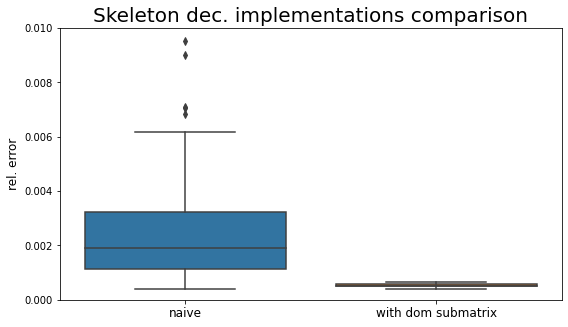

In [91]:
import seaborn as sns
import pandas as pd

plt.figure(figsize=(9, 5))
b = sns.boxplot(data=pd.DataFrame({'naive': rel_err[:, 0], 'with dom submatrix': rel_err[:, 1]}))
plt.title('Skeleton dec. implementations comparison', fontsize=20)
b.set_ylabel('rel. error')
plt.ylabel('rel. error', fontsize=12)
plt.xlabels = plt.xticks(fontsize=12)
plt.ylim(0, 0.01)
plt.show()

In [92]:
# sns.set(font_scale = 0.5)
# plt.style.use('default')

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [93]:
N = 500
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
xx, yy = np.meshgrid(x, y, sparse=True)
A = np.exp(-(xx**2 + yy**2)**0.5)

In [96]:
r = 3

print('Skeleton with dom. matrix:')
t = %timeit -o -q -r 20 -n 1 skeleton(A, r)
row_indices, col_indices = skeleton(A, r)
Ask = A[row_indices, :][:, col_indices]
Ar = A[:, col_indices] @ np.linalg.inv(Ask) @ A[row_indices, :]
rel_err = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')
print(fr'{t.average:.4f} +- {t.stdev:.4f} s, relative err: {rel_err:.4f}')

print('SVD:')
t = %timeit -o -q -r 20 -n 1 np.linalg.svd(A)
u, s, v = np.linalg.svd(A)
Ar = u[:, :r] @ np.diag(s[:r]) @ v[:r, :]
rel_err = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')
print(fr'{t.average:.4f} +- {t.stdev:.4f} s, relative err: {rel_err:.4f}')


Skeleton with dom. matrix:
0.0049 +- 0.0010 s, relative err: 0.0057
SVD:
0.0523 +- 0.0094 s, relative err: 0.0014


In [97]:
r = 25

print('Skeleton with dom. matrix:')
t = %timeit -o -q -r 3 -n 1 skeleton(A, r)
print(fr'{t.average:.4f} +- {t.stdev:.4f} s')

print('SVD:')
t = %timeit -o -q -r 20 -n 1 np.linalg.svd(A)
Ar = u[:, :r] @ np.diag(s[:r]) @ v[:r, :]
rel_err = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')
print(fr'{t.average:.4f} +- {t.stdev:.4f} s, relative err: {rel_err:.4f}')

Skeleton with dom. matrix:
Oops.. Can't find non-singular dominant submatrix of rank 25, please try lower rank
Oops.. Can't find non-singular dominant submatrix of rank 25, please try lower rank
Oops.. Can't find non-singular dominant submatrix of rank 25, please try lower rank
1.0301 +- 0.1227 s
SVD:
0.0563 +- 0.0268 s, relative err: 0.0000


Summary:

If it is easy to find initial submatrix of rank $r$ skeleton decomposition allows to achieve good approximation much faster than SVD, but if it isn't skeleton fails  